# **Chap 6：决策树**

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import make_moons,make_classification,make_circles
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
colors = sns.palettes.color_palette("muted")

决策树是一种基本的分类和回归方法，决策树采用树形数据结构，将决策过程模拟为**IF-ELSE**的条件语句判断形式，**IF-ELSE**规则集合构成了决策树的**参数空间**，这种参数空间相较数值空间在数学表示上相对抽象，但**非常易于理解模型的决策过程**

我们会首先介绍最原始的决策树模型**ID3**和**C4.5**，以了解决策树对数据的建模思想和训练过程，然后再引出当前最被广泛使用的**CART**决策树

## **1 决策树基础**

我们首先介绍**ID3**和**C4.5**两种决策树模型，它们用于解决**特征和标签均取值自离散空间的分类问题**

### **1.1 决策树**

决策树模型是一种对实例点进行划分的树形结构，由**结点**（`node`）和**有向边**（`edge`）组成，结点有两种类型：**内部结点**和**叶结点**
* 内部结点表示一个特征（或称为属性）
* 叶结点表示一种决策结果

在使用决策树进行预测时，从根结点开始，对实例的某一特征进行测试，然后根据**IF-ELSE**测试结果，将实例分配到对应的子结点，这时，**每一个子结点对应其父节点特征的一个取值**. 如此递归地对实例进行测试并分配结点，直到达到某个叶节点为止，最终预测节点即为该叶结点对应的类

下图展示了一棵决策树的基本结构

<img src="./source/Chap6/决策树示意图.png" width=600>

我们用**伪代码**将其表示为**IF-ELSE**的规则集合 $S$ 如下：

```python
# 假设下标从 1 开始
if x[2] == a_21:
    if x[1] == a_11:
        return C_1
    elif x[1] == a_12:
        return C_2
elif x[2] == a_22:
    if x[4] == a_41:
        if x[3] == a_31:
            return C_1
        elif x[3] == a_32:
            return C_2
        elif x[3] == a_33:
            return C_4
    elif x[4] == a_42:
        return C_3
```

上图中的决策树考虑了实例的4个特征 $(x^{(1)},x^{(2)},x^{(3)},x^{(4)})$，假设我们现在有某个实例 $x_0 = (a_{1,1},a_{2,2},a_{3,2},a_{4,1})$，则决策过程如下：
* 在根结点，对实例的第二个特征 $x^{(2)}$ 测试，$x^{(2)} = a_{2,2}$，**IF-ELSE**条件走`右侧`分支
* 新结点是内部结点，对实例的第四个特征 $x^{(4)}$ 测试，$x^{(4)} = a_{4,1}$，**IF-ELSE**条件走`左侧`分支
* 新结点是内部结点，对实例的第三个特征 $x^{(3)}$ 测试，$x^{(3)} = a_{3,2}$，**IF-ELSE**条件走`中间`分支
* 新结点是叶结点，完成预测，预测结果为 $C_3$

因此，我们可以把决策树看作**IF-ELSE**规则的集合，由决策树根结点到叶结点的每一条路径构成一条规则，路径上的内部结点的特征对应着规则的判断条件，儿叶结点的类别对应着规则得出的预测结论

决策树的路径与其对应的IF-ELSE规则集合需要满足**互斥且完备**的性质：
* **完备**表示：每一个实例**都能被**一条路径，或者说一条规则覆盖
* **互斥**表示：每一个实例**只能被**一条路径，或者说一条规则覆盖

**(1) 决策树模型**

决策树 $T$ 的模型参数空间 $\Theta$ 较为抽象，我们将其理解为**IF-ELSE**规则构成的集合 $S$ 的集合，但不是所有IF-ELSE规则 $S$ 都可以构成决策树，我们需要它完备且互斥，因此，设 $\Theta$ 表示所有完备且互斥的IF-ELSE规则集合 $S$ 组成的集合

则决策树模型简单记为：
$$f(x) = T(x;S)$$

模型的假设空间 $\mathcal{F}$ 为：
$$
\mathcal{F} = \{ f(x)=T(x;S) | S\in\Theta \}
$$

**(2) 决策树策略**

在进一步介绍决策树的学习策略之前，我们补充介绍**构建决策树过程中的样本划分和概率分布**

假设我们拥有训练数据集 $D=\{(x_i,y_i)\}_{i=1}^{N}$，其中 $x_i$ 是 $p$ 维向量，$y_i\in\{1,2,\cdots,K\}$ 属于离散空间，在决策树的一个内部结点 $\text{node}_k$ 处，假设该结点对应的特征为 $f_k$，则样本将会根据特征 $f_k$ 的取值划分到其对应的叶子结点处，该行为从根结点开始递归进行，直叶子结点到

回顾上面决策树的例子：

<img src="./source/Chap6/决策树示意图.png" width=600>

* 根结点包含整个训练数据集 $D$，它对应的特征是 $x^{(2)}$，根节点会根据 $x^{(2)}$ 对样本进行划分
* 根结点的左叶子结点包含样本子集 $D_1$，$D_1$ 中的所有实例都满足 $x^{(2)} = a_{2,1}$
* 根结点的左右子结点包含样本子集 $D_2$，$D_2$ 中的所有实例都满足 $x^{(2)} = a_{2,2}$
* 继续按照上述流程划分，每一个结点 $\text{node}_k$ 处都包含 $N_k$ 个样本，它们是数据集 $D$ 的子集

根据完备互斥远离，不难发现：

$$
|D| = \sum_{\text{node}_k \text{是叶子结点}} N_k.
$$

在每一个叶子结点处，假设该结点包含 $N_l$ 个样本，如果这 $N_l$ 个样本的标签全属于同一个，即 $y_i=k, \forall i$，则该结点称为**纯结点**（**pure node**），那么自然该叶结点的预测结果为 $k$，但决策树也允许叶子结点包含多个类别，考虑更一般的情况，假设对于 $k\in\{1,2,\cdots,K\}$，叶子结点包含 $y_i = k$ 的样本数量为 $N_{l,k}$ 个，则我们可以该结点上各类别的概率分布：

$$
\Pr(y = k) = \frac{N_{l,k}}{N_l},\quad k=1,2,\cdots,K
$$

因此，当给定样本实例 $x$ 时，首先决策树模型会根据**IF-ELSE**规则将其划分到某个叶子结点上，从而决定给定 $x$ 时标签的分布 $\Pr(y|x)$，然后就可以根据上式计算模型对 $x$ 所属概率的预测了：
$$
\Pr\left(T(x;S) = k\right) = \frac{N_{l,k}}{N_l},\quad k=1,2,\cdots,K
$$

决策树的建模策略与其他模型相同，对于一个分类问题，我们的目标是**极大化对数似然函数**，对于规则集合 $S$，对数似然函数为：

$$
R_{emp}(S) = L(S) = \log {\prod_{i=1}^{N} \left( {\prod_{k=1}^{K} \left[ \Pr\left(T(x_i;S) = k  \right)\right] ^{\mathbb{I}(y_i = k)}} \right) }
$$

因此，决策树决策规则为，基于历史数据集 $D$，**极大化经验对数似然函数** $R_{emp}(S)$：

$$
S^* = \mathop{\arg\max}\limits_{S\in\Theta} L(S)
$$

**(2) 决策树算法**

决策树的求解过程就是生成**IF-ELSE**规则集合 $S$ 的过程，我们希望生成的规则 $S$ 有以下两个性质：
* 对现有的历史数据（训练数据集）拟合的好
* 对未来的测试数据（测试数据集）同样有较好的泛化预测能力

由于决策树模型的参数 $S$ 不是简单的数值向量，而是具有层级抽象结构的规则集合，因此在求解极大化 $R_{emp}(S)$ 的优化问题时，我们**没办法像使用梯度下降算法那样来求解问题的解** 

一种基本的想法是**遍历参数空间** $\Theta$ 中的所有可行解 $S$，从而找到 $R_{emp}(S)$ 的极大值点，但很遗憾，为了遍历所有可能的规则集合，参数空间 $\Theta$ 的规模随着特征数量 $p$ 的增加**呈现指数级以上的增长速度**，这被证明是一个**NP完全**问题([P问题、NP问题、NPC问题、NP-hard问题详解](https://zhuanlan.zhihu.com/p/385907273))，在**时间复杂度**上不可行

因此，人们退而求其次，使用**启发式方法**，近似求解决策中定义的关于 $R_{emp}(S)$ 的最优化问题，这样得到的决策树规则 $S^*$ 是**次优的**

决策树学习的**启发式算法通常是一个递归的过程**，在每一步递归的过程中，**贪心地选择当前的最优决策方法**，这么做的直觉来自于，**每一步选择最优决策得到的结果和全局最优解不会差的太远**，基于这种想法，启发式算法往往能得到不错的结果

算法的具体执行上来说，核心步骤就是**分裂决策树**，在每一个内部结点上，我们执行两个操作：
* 选择当前结点处，**用于分裂的最优特征** $f_i$，即**特征选择问题**
* 基于所选择的 $f_i$，然后根据结点上样本特征 $f_i$ 的可能取值，**将样本划分到叶子结点**

以上过程递归执行，训练数据集会逐步进行分割，**使得叶子结点上的各个子数据集有一个很好的分类结果**，这一特征空间的划分过程对应了**IF-ELSE**规则的生成，算法流程上来看：
* 算法开始时，构造根节点，根节点包含了所有样本，选择一个最优特征，按照这一特征将训练集划分成为子集保存到每个叶子结点，**使得各个子集有一个在当前条件下的最好的分类结果**
* 如果某个子集已经能够基本正确分类（即**达到分裂的停止条件**，例如已经是一个**纯结点**），则将该结点设置为叶结点，停止它的分类
* 如果某个子集不能被基本正确分类，那么就对这些子集选择新的最优特征，继续进行**分裂操作**，构造相应的叶子结点，进行样本划分

如此递归的进行上面的步骤，直到当前所有处理的结点都成为了叶子结点或触发停止条件，则算法终止，**最后每个子集都会被划分到某个叶子结点上**

因此，决策树算法求解的最重要过程就是决定每一步的**特征选择**

简单来讲，特征选择过程希望**选取对训练数据具有最强分类能力的特征**，这样可以提高决策树学习的效率. 如果利用一个特征进行分类的结果**与随机分类的结果没有很大差别**，则可以认为这个特征没有分类能力，直觉上丢弃掉这部分特征对决策树学习的影响不大

我们以经典的买西瓜例子说明，假设特征有两个：拍打西瓜的声音和西瓜的外形，我们希望预测西瓜是否是甜瓜，训练样本如下表所示

<img src="./source/Chap6/西瓜例子.png" width=500>

不难发现：
* 如果我们选择**拍打声音**作为分裂特征，则划分得到的两个子集 $D_1,D_2$ 分别代表`清脆`和`沉闷`两种西瓜，并且此时**两个子集的标签全是同一种类型**，两个子集可以作为纯结点，因此**拍打声音**对于标签有很强的分类能力
* 如果我们选择**外形**作为分裂特征，则划分得到的两个子集 $D_1,D_2$ 分别代表`正圆`和`椭圆`两种西瓜，并且此时**两个子集的标签中，一半是甜，一半是不甜**，在每个子集 $D_i$ 上猜测西瓜甜度与在完整数据集 $D$ 上猜测的正确率没有区别，都是50%，因此**外形**对于标签没有任何分类能力

在数学上，我们可以用信息论中的熵的概念，来刻画一个变量对另一个变量的预测能力，我们称为**信息增益**（**Information Gain**）

回顾我们在**贝叶斯分类器**部分的**WAODE**算法，设 $X,Y$ 是两个离散随机变量，$X$ 的熵被定义为：
$$
H(X) = -\sum_{i=1}^{n} p_i\log p_i
$$
其中，概率 $p_i = \Pr(X= x_i),i=1,\cdots,n$，注意有：
$$
0\leq H(X)\leq \log n
$$
并且，**熵越大，说明随机变量的不确定性就越大**

条件熵 $H(Y|X)$ 表示在已知随机变量 $X$ 的情况下，随机变量 $Y$ 的不确定性，被定义为：
$$
H(Y|X) = \sum_{i=1}^{n} p_iH(Y|X=x_i)
$$

其中，$H(Y|X=x_i)$ 的计算使用条件概率分布 $\Pr(Y=y_j|X=x_i) = p_{j|i}$

最后，我们使用**互信息**来定义信息增益

**(Def) 信息增益**：给定某个特征（属性） $A$ 对训练数据集 $D$ 的信息增益 $g(D,A)$，定义为集合 $D$ 的经验熵 $H(D)$ 与特征 $A$ 给定下 $D$ 的经验条件熵 $H(D|A)$ 的差，即：
$$
g(D,A) = H(D) - H(D|A)
$$
**信息增益表示了，得到** $A$ **的信息，而使得数据集** $D$ **中类别标签信息的不确定性的减少程度**

假设训练数据集为 $D$，$|D|$ 表示样本量，设有 $K$ 个类 $C_k,k=1,\cdots,K$，$|C_k|$ 表示属于类别 $C_k$ 的样本个数，则：
$$
\sum_{k=1}^{K} |C_k| = |D| 
$$
设特征 $A$ 有 $n$ 个不同的取值 $\{a_1,a_2,\cdots,a_n\}$，根据特征 $A$ 的取值将 $D$ 可以划分为 $n$ 个子集 $D_1,D_2,\cdots,D_n$，则：
$$
\sum_{i=1}^{n} |D_i| = |D|
$$
记子集 $D_i$ 中属于类别 $C_k$ 的样本集合为 $D_{ik}$，即 $D_{ik} = D_i\cap C_k$，则：
$$
\sum_{k=1}^{K} |D_{ik}| = |D_i|
$$

则信息增益 $g(D,A)$ 的计算过程如下：
* 首先计算 $D$ 标签的经验熵 $D(D)$：
$$
H(D) = -\sum_{k=1}^{K} \frac{|C_k|}{|D|}\log \frac{|C_k|}{|D|}
$$
* 计算特征 $A$ 对于数据集 $D$ 的经验条件熵 $H(D|A)$：
$$
H(D|A) = \sum_{i=1}^{n}\frac{|D_i|}{|D|}H(D_i) = -\sum_{i=1}^{n}\frac{|D_i|}{|D|} \left( \sum_{k=1}^{K} \frac{|D_{ik}|}{|D_i|}\log \frac{|D_{ik}|}{|D_i|} \right)
$$
* 计算信息增益
$$
g(D|A) = H(D) - H(D|A)
$$

根据信息增益，在决策树特征选择的每一步，我们就可以计算当前数据集关于各个特征的信息增益 $g(D|A_i)$，然后选择信息增益最大的那一个特征

但人们发现，以信息增益作为标准选择特征，存在**偏向于选择取值较多的特征**的问题，因此提出**信息增益比**（**Information Gain Ratio**）对这一问题进行校正，这是决策树进行特征选择的另一个准则

**(Def 信息增益比)**：特征 $A$ 对训练数据集 $D$ 的信息增益比 $g_R(D,A)$ 定义为其**信息增益** $g(D,A)$ 与**训练数据集** $D$ **关于特征** $A$ **的值的熵** $H_A(D)$  之比，即：
$$
g_R(D,A) = \frac{g(D,A)}{H_A(D)}
$$
其中，熵 $H_A(D)$ 计算为：
$$
H_A(D) = -\sum_{i=1}^{n} \frac{|D_i|}{|D|} \log \frac{|D_i|}{|D|}
$$
$n$ 是特征 $A$ 取值的个数

### **1.2 ID3和C4.5决策树**

下面介绍的ID3和C4.5决策树模型，核心区别仅在于它们**特征选择的准则不同**：
* ID3使用信息增益 $g(D,A)$
* C4.5使用信息增益比 $g_R(D,A)$

#### **1.2.1 ID3**

我们再为决策树模型的学习过程添加几条**停止条件**，就可以构成完整的学习算法了，条件主要包含三条：
* 如果当前结点保存的子集全是同一个类别 $C_k$，即该结点是**纯结点**，则将该结点设置为叶结点，停止继续分裂，叶结点预测结果设置为 $C_k$
* 如果当前结点已经**没有可用的分裂特征**，则将该结点设置为叶结点，停止继续分裂，叶结点预测结果使用**投票机制**确认
* 如果当前结点所选择的最优分裂特征 $A^*$ 取得的信息增益 $g(D,A^*)$ 小于某个阈值 $\varepsilon$，则**认为没有分裂必要**，将该结点设置为叶结点，停止继续分裂，叶结点预测结果使用**投票机制**确认

下面，我们用标准流程介绍ID3决策树的生成算法

**(Algo) ID3决策树生成算法**
* **输入**：数据集 $D$，特征集合 $\mathcal{A}$，阈值 $\varepsilon > 0$
* **输出**：决策树结点 $T$
* **算法流程**：
    * (1) 若 $D$ 中所有实例都属于同一类别 $C_k$，则 $T$ 为纯结点，将 $T$ 设置为叶结点，并将 $C_k$ 设置为该叶子的预测结果，返回 $T$
    * (2) 若 $\mathcal{A} = \emptyset$，将 $T$ 设置为叶结点，并使用投票机制确认该叶子的预测结果，返回 $T$
    * (3) 若否，对每一个 $A_i\in\mathcal{A}$，计算结点的**信息增益** $g(D,A_i)$，并选择 $A^* = \mathop{\arg\max}\limits_{A_i} g(D,A_i)$
        * (3.1) 若 $A^*$ 的信息增益小于 $\varepsilon$，则将 $T$ 设置为叶结点，并使用投票机制确认该叶子的预测结果，返回 $T$
        * (3.2) 若否，对 $A^*$ 的每一可能取值 $a_i$，依 $A^* = a_i$ 将 $D$ 划分为若干个非空子集 $D_i$，将 $D_i$ 中实例数最多的类作为该结点的标记，构造子结点，由该结点及其子结点构成树 $T$
        * (3.3) 对 $T$ 的第 $i$ 个子结点，以 $D_i$ 为训练集，$\mathcal{A} - A^*$ 为特征集合，递归调用 (1) ~ (3) 步，直到算法停止 返回 $T$

#### **1.2.2 C4.5**

C4.5决策树和ID3决策树的**唯一区别在于特征选择的准确替换为信息增益比**，我们不做过多介绍，直接给出算法流程

**(Algo) C4.5决策树生成算法**
* **输入**：数据集 $D$，特征集合 $\mathcal{A}$，阈值 $\varepsilon > 0$
* **输出**：决策树结点 $T$
* **算法流程**：
    * (1) 若 $D$ 中所有实例都属于同一类别 $C_k$，则 $T$ 为纯结点，将 $T$ 设置为叶结点，并将 $C_k$ 设置为该叶子的预测结果，返回 $T$
    * (2) 若 $\mathcal{A} = \emptyset$，将 $T$ 设置为叶结点，并使用投票机制确认该叶子的预测结果，返回 $T$
    * (3) 若否，对每一个 $A_i\in\mathcal{A}$，计算结点的**信息增益比** $g_R(D,A_i)$，并选择 $A^* = \mathop{\arg\max}\limits_{A_i} g_R(D,A_i)$
        * (3.1) 若 $A^*$ 的信息增益小于 $\varepsilon$，则将 $T$ 设置为叶结点，并使用投票机制确认该叶子的预测结果，返回 $T$
        * (3.2) 若否，对 $A^*$ 的每一可能取值 $a_i$，依 $A^* = a_i$ 将 $D$ 划分为若干个非空子集 $D_i$，将 $D_i$ 中实例数最多的类作为该结点的标记，构造子结点，由该结点及其子结点构成树 $T$
        * (3.3) 对 $T$ 的第 $i$ 个子结点，以 $D_i$ 为训练集，$\mathcal{A} - A^*$ 为特征集合，递归调用 (1) ~ (3) 步，直到算法停止 返回 $T$

### **1.3 决策树剪枝**

几乎任何机器学习算法都会考虑**模型的正则化**问题，以防止过拟合发生，**剪枝**（**pruning**）操作就是决策树的正则化手段

决策树生成算法递归地产生决策树，直到不能继续下去为止，这样得到的树往往对训练数据的分类很准确，**但对未知的测试数据的分类却没有那么准确**，即出现了**过拟合**现象，过拟合的原因在于学习过程中**过多地考虑了如何提高对训练数据的正确分类**，从而构造出了**过于复杂的决策树**，解决该问题的方法是**考虑决策树的负责度**，对已经生成的决策树及逆行简化，该过程称为**剪枝**

我们可以这样理解决策树的生成和剪枝过程：
* 生成过程：对应于模型的**局部选择**，生成只考虑模型的**局部最优**
* 剪枝过程：对应于模型的**全局选择**，剪枝考虑选择**全局最优**的决策树

下面介绍一种简单的决策树剪枝算法，首先，我们需要定义决策树学习的损失函数

设决策树 $T$ 的叶结点个数为 $|T|$，$t$ 是 $T$ 的叶结点，该叶结点包含 $N_t$ 个样本，其中 $k$ 类样本有 $N_{tk},k=1,\cdots,K$ 个，$H_t(T)$ 定义为叶结点熵的经验熵，即：
$$
H_t(T) = -\sum_{k=1}^{K} \frac{N_{tk}}{N_t} \log \frac{N_{tk}}{N_t}
$$

$a \geq 0$ 是超参数，则决策树模型的损失函数可以定义为：
$$
C_a(T) = a|T| + \sum_{t=1}^{|T|} N_tH_t(T)
$$

损失函数中的第二项可以写作 $C(T)$：
$$
C(T) = \sum_{t=1}^{|T|} N_tH_t(T) = -\sum_{i=1}^{|T|} \sum_{k=1}^{K} N_{tk} \log \frac{N_{tk}}{N_t}
$$

此时，完整的损失函数可以写作：
$$
C_a(T) = C(T) + a|T|
$$

我们可以看到，$C(T)$ 用于**表示模型对训练数据的预测误差**（极端情况下，假设每个叶结点都是纯结点，都预测正确，那么每个叶结点的经验熵等于 $0$，整个树对训练集的误差 $C(T) = 0$，另一种极端情况是每个叶结点下的样本子集的标签均匀分布在 $K$ 个类别下，叶结点失去预测能力，此时每个叶结点的熵等于最大值 $\log K$，整个模型的误差也取到极大值 $C(T) = |D|\cdot \log K$）

损失函数中另一项 $|T|$ 表示模型复杂度，$a\geq 0$用于控制两者之间的影响，**较大的** $a$ **促使选择较简单的决策树模型**，较小的 $a$ 促使选择相对复杂的决策树模型，**极端情况** $a = 0$ **意味着只考虑模型拟合误差，不考虑复杂度**

到剪枝的具体过程是，首先我们不为模型增加惩罚，得到一颗最复杂的树 $T$，然后给定 $a$ 时，选择损失函数最小的模型，即损失函数值最小的 $T$ 的子树，这通过剪去 $T$ 的一些分支完成，得到最优子树 $T^*$
* 子树 $T^*$ 越大，往往与训练数据拟合的越好，但模型复杂度就越高，容易**过拟合**
* 子树 $T^*$ 越小，但模型复杂度就越低，但可能与训练数据拟合不好，容易**欠拟合**  

而损失函数 $C_a(T)$ 考虑了上面二者之间的平衡

不难理解，极小化 $C_a(T)$ 等价于求解**含有正则项的极大似然函数**，因此利用损失函数最小化进行剪枝，等价于我们用正则化的极大似然函数估计模型

下面给出剪枝的具体算法

**(Algo) 决策树剪枝**  
* **输入**：生成算法得到的完整树 $T$，惩罚项系数 $a$
* **输出**：剪枝后的决策树 $T_a$
* **算法流程**：
    * (1) 计算每个叶子的经验熵
    * (2) **递归地**从树的叶结点开始**向上回缩**，设一组叶结点回缩到其父节点之前与之后的整体树分别为 $T_{\text{before}}$ 与 $T_{\text{after}}$，如果满足：
    $$ C_a(T_{\text{after}}) \leq C_a(T_{\text{before}})$$
    则进行剪枝，将这组叶结点的父节点变为新的叶结点
    * (3) 返回(2)，直到不能继续为止，得到损失函数最小的子树 $T_a$

在比较 $ C_a(T_{\text{after}}), C_a(T_{\text{before}})$ 时，注意到**此时整棵树的结构仅在该局部发生改变**，我们**仅需计算该局部变化**对 $|T|$ 和 $C(T)$ **的变化量即可**，无需重新计算整棵树的损失函数 $C_a(T)$

最后，我们说明两点：
* ID3和C4.5是**多叉树**，每个结点可以有很多个子节点，这和后面介绍的CART树有很大不用
* 上面的剪枝方法是**后剪枝**，即在完整的树生成后才剪枝，后面还会介绍另一种剪枝方法称为**预剪枝**

### **1.4 决策树的实现**

我们以ID3为例，来实现简单的决策树的**生成算法**

首先，我们定义函数`empirical_entropy()`和`information_gain()`用于计算经验熵和信息增益

In [2]:
def empirical_entropy(labels : np.ndarray):
    """
    计算经验熵
    """
    N = len(labels)
    labels_cnts = Counter(labels) # 统计频数
    labels_prob = [v/N for v in labels_cnts.values()] # 统计概率
    H = -sum(p*np.log(p) for p in labels_prob) # 计算熵
    return H

In [3]:
def information_gain(X : np.ndarray, attr : int, labels : np.ndarray):
    """
    Parameters
    ----------
    X : np.ndarray
        样本实例，维度`(N,p)`
    attr : int
        计算信息增益所提供的特征索引，取值`[0,1,...,p-1]`
    labels : np.ndarray
        样本实例对应的标签
    
    return
    ----------
    IG : float
        返回给定 `attr` 时的信息增益`IG = g(D,A)`
    """
    # 计算经验熵 H(D)，先统计概率，再计算熵
    N = len(labels)
    H_D = empirical_entropy(labels)
    # 计算条件熵 H(D|A)
    H_DA = 0
    attr_cnts = Counter(X[:,attr])
    for k,v in attr_cnts.items():
        # 样本子集 D_i 索引
        subset_idx = (X[:,attr] == k)
        # 计算经验熵 H(D_i)
        H_DA += v/N * empirical_entropy(labels[subset_idx])
    # 计算信息增益
    IG = H_D - H_DA
    return IG

其次，我们需要定义树的每个结点类`TreeNode`，该结点类主要提供以下两个功能：
* 存储结点包含的样本`data_idx`、标签`labels`、结点所属的类别`label`，结点叶子`children`等其他基本信息
* 提供结点的分裂方法`split()`

In [4]:
class TreeNode:
    def __init__(self, data_idx : np.ndarray, labels : np.ndarray):
        """
        data_idx : np.ndarray
            保存在该结点的样本索引
        labels : np.ndarray
            结点样本对应标签
        """
        # 该结点包含的样本实例，仅保存索引
        self.data_idx = data_idx
        self.labels = labels
        
        # 该结点的标签，统计众数
        self.label = Counter(labels).most_common()[0][0]
        
        self.children = None # 保存叶子结点
        self.is_leaf = False # 是否是叶子结点
        self.split_feature = None # 分裂所使用的特征
    
    def split(self, X : np.ndarray, A : set, eps : float):
        """
        分裂该结点
        
        X : np.ndarray
            样本，通过`data_idx`访问子集
        A : set
            用于分裂的特征集合
        eps : float
            判断信息增益使用的阈值
        """
        # 停止条件1：结点为纯结点
        # 停止条件2：没有可用的分裂特征
        if len(np.unique(self.labels)) == 1 or A is None:
            self.is_leaf = True
            return self
        
        # 计算各个特征的信息增益，并找到最优分裂特征
        IG, best_attr, best_IG = {}, None, 0
        for attr in A:
            IG[attr] = information_gain(X[self.data_idx],attr,self.labels)
            # 更新最优分裂特征
            if IG[attr] > best_IG:
                best_IG = IG[attr]
                best_attr = attr
        
        # 停止条件3：信息增益小于阈值
        if best_IG < eps:
            self.is_leaf = True
            return self
        
        # 若否，开始分裂，并创造子结点
        self.children = {} # 用字典存储叶子结点，key表示特征取值
        self.split_feature = best_attr
        A_new = A.remove(best_attr) # 从特征集合中移除 best_attr
        # 顺序迭代 best_attr 的每一种可能取值
        for val in np.unique(X[self.data_idx,best_attr]):
            # 定位样本子集索引和标签
            subset_idx = self.data_idx & (X[:,best_attr] == val)
            subset_labels = self.labels[X[self.data_idx,best_attr] == val]
            # 创建子结点，并递归分裂
            self.children[val] = TreeNode(subset_idx,subset_labels)
            self.children[val].split(X,A_new,eps)

接下来，只需要将上面定义的`TreeNode`组合，就可以把结点拼接成为决策树`DecisionTreeID3`啦

我们仿照`sklearn`的函数接口来设计自己编写的模型，参照一个优秀的程序范本学习并应用有助于程序编写能力的提升

In [5]:
class DecisionTreeID3:
    def __init__(self, eps : float=1e-3):
        """
        eps : float
            设定停止分裂的信息增益判断阈值
        """
        self.eps = eps
        self.root = None
    
    def fit(self, X : np.ndarray, y : np.ndarray):
        """
        训练模型
        """
        # 创建样本索引，创建根节点
        data_idx = np.bool_(np.ones(len(X)))
        self.root = TreeNode(data_idx,y)
        # 创建特征集合
        A = set(list(range(X.shape[1])))
        # 分裂决策树
        self.root.split(X,A,self.eps)
    
    def predict(self, X : np.ndarray):
        """
        进行预测
        """
        preds = []
        for x in X:
            node = self.root # 拷贝根节点的指针
            # 直到划分到叶结点
            while not node.is_leaf:
                attr = node.split_feature # 该结点分裂的特征
                # 做一个保护，对于特征 attr
                # 有可能测试集中含有训练集中未出现的取值
                try:
                    node = node.children[x[attr]] # 根据取值找到对应叶子
                except:
                    break
            # 做出预测
            preds.append(node.label)
        return np.array(preds)

我们来导入一个简单的**贷款申请数据集**来测试下我们的决策树

In [6]:
data = pd.read_csv("./source/Chap6/贷款申请数据集.csv")
data.head()

,年龄,有工作,有房子,信贷情况,是否贷款
0,青年,否,否,一般,否
1,青年,否,否,好,否
2,青年,是,否,好,是
3,青年,是,是,一般,是
4,青年,否,否,一般,否


In [7]:
# 选择特征
y = data.pop("是否贷款").values
X = data.values

In [8]:
# 创建模型，进行训练
model = DecisionTreeID3()
model.fit(X,y)
# 评估准确率
y_pred = model.predict(X)
print("训练集准确率：%.4f"%(accuracy_score(y,y_pred)))

训练集准确率：0.8000


我们可以**查看根节点分裂所使用的特征**，了解哪个特征对于决定是否发放贷款最为重要

In [9]:
print("根节点分裂特征：",data.columns[model.root.split_feature])

根节点分裂特征： 有房子


嗯，看样子**有房才是最重要的**😅😅😅

----

## **2 现代决策树CART**

CART树称为分类与回归决策树（**Classification and Regression Tree**），之前介绍的ID3和C4.5决策树的设计主要解决**特征属于离散空间的分类问题**，CART通过一个整体的框架，能够同时解决分类和回归问题

### **2.1 CART树模型**

这里我们主要介绍CART树与ID3和C4.5的区别，总体上来说，CART树的训练依然包括**决策规则创建**和**决策树剪枝**两部分

最大的区别在于，在决策规则的创建阶段，CART将决策树固定为**二叉树**，每个决策问题变为一个**是/否**决策，左子结点表示**是分支**，右子结点表示**否分支**

经过这样的处理后，我们可以分别考虑**数值特征**（numerical variable）和**离散特征**（categorical variable）：
* 对于某个**数值特征** $x^{(i)}\in\mathbb{R}$，我们取特征 $x^{(i)}$ 的某个分割点 $s\in\mathbb{R}$，那么**左右子结点分支**的样本可以定义为：
$$
L = \{x\in D|x^{(i)} \leq s\},\quad R = \{x\in D|x^{(i)} > s\}
$$
* 对于某个**离散特征** $x^{(i)} \in \{a_{i,1},\cdots,a_{i,n_i}\}$，我们取特征 $x^{(i)}$ 的某个可能取值 $a\in \{a_{i,1},\cdots,a_{i,n_i}\}$，那么**左右子结点分支**的样本可以定义为：
$$
L = \{x\in D|x^{(i)} = a\},\quad R = \{x\in D|x^{(i)} \ne a\}
$$

在一些实现框架中，可以将**离散的类别变量**进行编码（**独热编码**或者**顺序编码**），则**编码后的离散特征也可以当作数值特征使用**

**CART树的决策过程以ID3和C4.5相同**，我们将训练集 $D$ 划分到多个叶子结点后，**每个叶子结点就构成了一个关于标签** $y$ **的分布**，我们基于该分布，结合预先设定的损失函数，就可以确认该叶子结点上的预测标签：
* 对于分类问题，当损失函数是**0-1损失**时，最优预测标签是取每个叶子结点上标签的**投票**结果
* 对于回归问题，当损失函数是**平方损失**时，最优预测标签是取每个叶子结点上标签的**平均值**

最后，CART树的生成算法依然采用**启发式算法**，确认一个**分裂评估准则**，在每一步分裂时选择最优分裂决策，递归进行，我们接下来具体来看**CART回归树**和**CART分类树**的生成过程

### **2.2 分类问题和回归问题**

#### **2.2.1 CART回归树**

我们介绍使用**平方误差**作为损失函数的CART回归树，通常又称为**最小二乘回归树**

下面假设特征空间 $X$ 是数值空间，即 $X = \mathbb{R}^p$，标签 $Y$ 也是连续变量，训练集 $D = \{(x_i,y_i)\}_{i=1}^{N}$

一颗决策树的规则集合将特征空间划分到多个叶子结点，假设已经将空间划分到 $M$ 个单元 $R_1,R_2,\cdots,R_M$，每个叶子结点的预测输出为 $c_m$，则回归树模型的决策函数可以表示为：


$$
f(x) = \sum_{m=1}^{M} c_m\mathbb{I}(x\in R_m)
$$

当输入空间划分确定时，每个叶子结点处的损失函数为：
$$
\sum_{x_i\in R_m} \left[y_i - f(x_i)\right]^2 = \sum_{x_i\in R_m} \left[y_i -c_m)\right]^2,\quad m=1,\cdots,M
$$

因此，当使用平方误差时，每个单元 $R_m$ 上的 $c_m$ 的最优值 $\hat{c}_m$ 是 $R_m$ 上所有标签的均值，即：
$$
\hat{c}_m = \frac{1}{|R_m|} \sum_{x_i\in R_m} y_i,\quad m=1,\cdots,M
$$

接下来考虑**CART回归树的分裂过程**，在每次分裂时，选择第 $j$ 个特征 $x^{(j)}$ 和它取值空间的某个点 $s\in\mathbb{R}$ 作为**切分变量**和**切分点**，定义**左右子结点**区域：

$$
L(j,s) = \{x\in D|x^{(j)} \leq s\},\quad R(j,s) = \{x\in D|x^{(j)} > s\}
$$

接下来，我们只需要**确认每步分裂时的最优切分变量** $j^*$ **及其对应的最优切分点** $s^*$，求解优化问题：

$$
(j^*,s^*) = \mathop{\arg\min}\limits_{j,s}\left[ \min_{c_1} \sum_{x_i\in L(j,s)}(y_i - c_1)^2 + \min_{c_2} \sum_{x_i\in R(j,s)}(y_i - c_2)^2 \right]
$$

内层关于子结点区域的标签 $c_1,c_2$ 的极小化问题在前面已经说明，**给定** $(j,s)$ 后，只需要选取均值：

$$
c_1 = \frac{1}{|L(j,s)|} \sum_{x_i\in L(j,s)}y_i,\quad c_2 = \frac{1}{|R(j,s)|} \sum_{x_i\in R(j,s)}y_i
$$

因此，每次分裂时，我们**遍历所有输入特征**，对每个特征 $j$，然后遍历 $x^{(j)}$ 的可能取值作为切分点 $s$，构成一对 $(j,s)$，依次将特征空间划分到两个区域，直到满足停止条件

上面的切分点 $s$ 的选择问题在实际应用中可能会有**计算复杂度**过高的问题，假设样本量 $N$ 很大，而对于某个特征 $j$，**数值型特征** $x^{(j)}\in\mathbb{R}$ **的可能取值非常多**，如果让切分点 $s$ 遍历所有可能的取值，则仅对某个特征 $j$ 就需要求解 $(j,s)$ 的优化问题 $\mathcal{N}$ 次，这非常耗时

一种简单的优化方法是，当**样本量相对大时**，**切分点** $s$ **仅遍历** $x^{(j)}$ **的分位数点**，例如取 $0.1, 0.2, \cdots, 0.9$ 分位数，则遍历次数会从 $\mathcal{O}(N)$ 降低到 $\mathcal{O}(1)$，而当**样本量相对较小时**（例如小于20个），则可以直接遍历所有可能取值

我们将CART回归树的算法叙述如下：

**(Algo) CART回归树**
* **输入**：训练数据集 $D$
* **回归树**：$f(x)$
* **算法流程**：
    * (1) 在当前结点上，选择最优切分变量 $j$ 和切分点 $s$，遍历变量 $j$，对固定的变量 $j$ 扫描切分点 $s$，求解优化问题：
    $$
    (j^*,s^*) = \mathop{\arg\min}\limits_{j,s}\left[ \min_{c_1} \sum_{x_i\in L(j,s)}(y_i - c_1)^2 + \min_{c_2} \sum_{x_i\in R(j,s)}(y_i - c_2)^2 \right]
    $$
    * (2) 用得到 $(j^*,s^*)$ 划分样本，并求解子结点区域标签：
    $$
    L(j^*,s^*) = \{x\in D|x^{(j^*)} \leq s^*\},\quad R(j^*,s^*) = \{x\in D|x^{(j^*)} > s^*\} \\
    c_1 = \frac{1}{|L(j^*,s^*)|} \sum_{x_i\in L(j^*,s^*)}y_i,\quad c_2 = \frac{1}{|R(j^*,s^*)|} \sum_{x_i\in R(j^*,s^*)}y_i
    $$
    * (3) 继续对两个子区域调用 (1) 和 (2)，直到满足停止条件
    * 算法停止后，输入空间被划分到 $M$ 个叶子结点区域 $R_m,m=1,\cdots, M$，决策函数为：
    $$
    f(x) = \sum_{i=1}^{M} \hat{c}_m\mathbb{I}(x\in R_m)
    $$

#### **2.2.2 CART分类树**

算法流程上，CART分类树与回归树没有太多区别，只是分裂决策的准则不同，**CART分类树使用Gini系数**

**(Def) Gini系数**：分类问题中，假设有 $K$ 个类，样本点属于第 $k$ 个类的概率为 $p_k$，则概率分布的Gini系数为：
$$
\text{Gini}(p) = \sum_{k=1}^{K}p_k(1-p_k) = 1 - \sum_{k=1}^{k}p_k^2
$$
对于二分类问题，若样本点属于正类的概率为 $p$，则概率分布的Gini系数为：
$$
\text{Gini}(p) = 2p(1-p)
$$
对于给定数据集 $D$，我们计算经验Gini系数：
$$
\text{Gini}(D) = 1 - \sum_{k=1}^{K} \frac{|C_k|}{|D|}
$$

**Gini系数与前面介绍的信息增益的作用相同**，我们还可以定义**条件基尼系数**，如果样本集合 $D$ 根据分裂特征 $j$ 及其分裂点 $s$ 划分为 $L(j,s)$ 和 $R(j,s)$ 两个子集，则将**给定划分** $(j,s)$ **条件下**，**集合** $D$ **的Gini系数**为：

$$
\text{Gini}(D;j,s) = \frac{|L(j,s)|}{|D|}\text{Gini}(L(j,s)) + \frac{|R(j,s)|}{|D|}\text{Gini}(R(j,s))
$$

**Gini系数** $\text{Gini}(D)$ **表示集合** $D$ **的不确定性**，而条件Gini系数 $\text{Gini}(D;j,s)$ 表示经过分裂决策 $(j,s)$ 后集合 $D$ 的不确定性

接下来，每次分类时**确认最优切分变量** $j^*$ **及其对应的最优切分点** $s^*$，求解优化问题：

$$
(j^*,s^*) = \mathop{\arg\min}\limits_{j,s}\left[ \text{Gini}(D;j,s) \right]
$$

子结点区域划分完成后，每个子结点的预测标签使用**投票机制**确认，即取标签的众数：

$$
c_1 = \text{mode}\left(\{y_i|x_i\in L(j^*,s^*)\}\right),\quad c_2 = \text{mode}\left(\{y_i|x_i\in R(j^*,s^*)\}\right)
$$

我们将CART分类树的算法叙述如下：

**(Algo) CART分类树**
* **输入**：训练数据集 $D$
* **回归树**：$f(x)$
* **算法流程**：
    * (1) 在当前结点上，选择最优切分变量 $j$ 和切分点 $s$，遍历变量 $j$，对固定的变量 $j$ 扫描切分点 $s$，求解优化问题：
    $$
    (j^*,s^*) = \mathop{\arg\min}\limits_{j,s}\left[ \text{Gini}(D;j,s) \right]
    $$
    * (2) 用得到 $(j^*,s^*)$ 划分样本，并求解子结点区域标签：
    $$
    L(j^*,s^*) = \{x\in D|x^{(j^*)} \leq s^*\},\quad R(j^*,s^*) = \{x\in D|x^{(j^*)} > s^*\} \\
    c_1 = \text{mode}\left(\{y_i|x_i\in L(j^*,s^*)\}\right),\quad c_2 = \text{mode}\left(\{y_i|x_i\in R(j^*,s^*)\}\right)
    $$
    * (3) 继续对两个子区域调用 (1) 和 (2)，直到满足停止条件
    * 算法停止后，输入空间被划分到 $M$ 个叶子结点区域 $R_m,m=1,\cdots, M$，决策函数为：
    $$
    f(x) = \sum_{i=1}^{M} \hat{c}_m\mathbb{I}(x\in R_m)
    $$

#### **2.2.3 算法停止条件**

CART树的算法停止条件与ID3和C4.5类似，我们分回归问题和分类问题给出

**(1) 分类问题**
* 当前结点变为**纯结点**，则无需继续分裂
* 当前结点所有分裂决策的**Gini系数小于给定阈值** $\varepsilon$，则无需继续分裂
* 在**所有特征都是离散特征**，并且**离散特征已经使用完毕**，则无需继续分裂

注意，如果数据中特征空间 $X$ 包含数值特征，数值特征不会存在**特征使用完毕**的情况

**(2) 回归问题**
* 当前结点的误差小于给定阈值 $\varepsilon$，即在某个结点 $R$ 上，最优预测 $\hat{c}$ 为其所包含样本的标签均值，如果有：
$$
\frac{!}{|R|} \sum_{x_i\in R} \left(y_i - hat{c}\right)^2 <\varepsilon
$$
则无需继续分裂
* 在**所有特征都是离散特征**，并且**离散特征已经使用完毕**，则无需继续分裂

### **2.3 CART树剪枝**

#### **2.3.1 后剪枝**

CART树的预剪枝与ID3和C4.5的思路相似，我们考虑一个带正则化的损失函数 $C_a(T)$：
$$
C_a(T) = C(T) + a|T|
$$

其中，$T$ 是任意子树，$C(T)$ 为对训练数据的预测误差，例如**分类问题可以使用Gini系数**，**回归问题使用均方误差**，$|T|$ 表示子树中叶子结点的个数，$a\geq 0$ 是惩罚权重参数，用于权衡训练数据的拟合误差和模型复杂度

对固定的 $a$，一定存在使得损失 $C_a(T)$ 最小的子树，将其表示为 $T_a$，即：
$$
T_a = \mathop{\arg\min}\limits_{T} C_a(T)
$$

当 $a$ 增大时，子树 $T_a$ 偏小，当 $a$ 减小时，子树 $T_a$ 偏大，考虑极端情况，当 $a=0$ 时，**整棵树是最优**的，当 $a\to \infty$ 时，**根节点作为唯一叶子结点的树是最优的**

我们可以用如下**递归**的方法对树进行剪枝，将 $a$ 从小增大，即 $0=a_0<a_1<a_2,<\cdots<a_n<+\infty$，产生一系列区间 $[a_i,a_{i+1}),i=0,1,\cdots,n$，剪枝得到的子树序列 $T_a$ 对应着区间 $a\in [a_i,a_{i+1}),i=0,1,\cdots,n$ 的最优子树序列 $\{T_0,T_1,\cdots,T_n\}$，**序列中的子树是嵌套的**

具体地，从整棵树 $T_0$ 开始剪枝，对 $T_0$ 的任意内部结点 $t$，以 $t$ 为单结点树的损失函数为：
$$
C_A(t) = C(t) + a
$$

以 $t$ 为根节点的子树 $T_t$ 的损失函数为：
$$
C_a(T_t) = C(T_t) + a|T_t|
$$

不难发现，当 $a=0$ 或 $a\to 0$ 时，成立：
$$
C_a(T_t) < C_a(t)
$$

继续增大 $a$，到某一时刻会有 $C_a(T_t) = C_a(t)$，继续增大，上面的不等式反向，因此只要：
$$
a = \frac{C(t) - C(T_t)}{|T_t| - 1}
$$
$T_t$ 和 $t$ 就有相同的损失函数值，而 $t$ 只有一个结点、结点数量少，比 $T_t$ 更简单，对 $T_t$ 进行剪枝，回退成为叶子结点

为此，我们可以针对完整树 $T_0$ 的每一个内部结点 $t$，计算 $g(t)$：
$$
g(t) = \frac{C(t) - C(T_t)}{|T_t| - 1}
$$

$g(t)$ 表示**剪枝后整体损失函数减小的程度**

在 $T_0$ 中减去 $g(t)$ 最小的 $T_t$，将得到的子树作为 $T_1$，同时将最小的 $g(t)$ 记为 $a_1$，**则** $T_1$ **就是区间** $a\in[a_1,a_2)$ **的最优子树**

重复上述步骤，按从小到大的顺序选择 $g(t)$，直到树的根节点，在这一过程中，$a$ **的值不断增大，产生新的区间，得到嵌套的决策树序列**

得到子树序列 $\{T_0,T_1,\cdots,T_n\}$后，利用独立的**交叉验证数据集**，**测试每棵树在验证集上的性能，寻找最优子树，完成剪枝**

#### **2.3.2 预剪枝**

预剪枝与前面介绍的剪枝算法都不同，前面介绍的剪枝算法都属于**后剪枝**算法，及特点是**生成整个完整的树，在逐步判断是否删除一些枝叶**

下面介绍的**预剪枝**方法的思想是，**在树的生成过程中就限制树的规模，生成的过程中就完成剪枝**

**预剪枝实现简单**，且易于理解，是目前主流的剪枝手段，它通过**引入一些超参数来限制树的规模**，以达成剪枝的目的

我们在这里介绍两个最主流的超参数，其余超参数可以参见`sklearn`的相应函数的说明文档：
* **最大树深度**，`max_depth`
* **最小叶结点样本数**：`min_samples_leaf`
* **最大分裂特征数**：`max_features`

**(1) 最大树深度**

通常来说，**决策树过拟合**的原因是决策树在拟合训练数据时**钻牛角尖**，我们希望得到的决策树应该是**体型适中**，偏向于**向四周发展茂密枝叶**，这样的树一般有较强的泛化能力，而不希望得到**只往高处长**的树（这里的高指的就是深度），如下图所示

<img src="./source/Chap6/决策树对比.png" width=400>

因此，一种剪枝的方法是**限制决策树的最大深度**，决策树从根节点开始，每向下分裂一次，深度增加 1，根节点的深度为 0

在决策生成过程中，我们**检查当前分裂产生的树的深度**，如果**深度会大于**`max_depth`，**则停止分裂**，将当前结点设置为叶结点

**(2) 最小叶结点样本数**

我们已经清楚，**每个叶节点包含的样本决定了该叶结点的预测结果**，如果**将决策树和KNN**对比，给定实例 $x$ 时，决策树将其划分到所属的叶结点区域，KNN找到距离该样本最近的 $k$ 个邻居样本，我们都是基于这些特征空间中”子区域“的样本来推断预测 $x$ 的标签

联想KNN中过拟合和欠拟合的控制，那么自然地：
* 叶结点上的样本越少，近似误差越小，泛化误差越大，模型越容易**过拟合**，这是一个**高方差模型**
* 叶结点上的样本越多，近似误差越大，泛化误差越小，模型越容易**欠拟合**，这是一个**高偏差模型**

在决策树生成过程中，我们检查当前分裂产生的叶结点的样本量，**只有左右叶结点的样本量都不小于**`min_samples_leaf`，分裂才会进行

据此，如果我们发现，**某个结点当前包含的样本量小于**`2*min_samples_leaf`，**则直接不考虑分裂该结点**

需要注意，设置`min_samples_leaf > 1`意味着开启了最小叶结点数样本树的限制，这**在一定程度上也会限制生成树的深度**

**(3) 最大分裂特征数**

根据之前的学习，我们知道当**特征维度** $p$ **接近样本量** $N$，或甚至在**高维问题**中可以远大于样本量 $N$ 时，**模型非常容易过拟合**

因此，一种方法是限制决策树在分裂时所考虑的特征数量，这在一定程度上也能**缓解过拟合**（事实上，这是一种**给模型引入随机性**的方法，**大部分为模型引入随机性的方法，都能在一定程度上环节过拟合**，这在我们之后的学习过程中会加深对这一事实的理解）

因此，在每个结点考虑分裂时，我们从 $p$ 个特征中随机采样`max_features`个，在这一轮分割特征和切分点的搜索时，就仅限制在这部分特征子集上进行

最后，**预剪枝的超参数可以通过交叉验证的方法确定**

### **2.4 特征重要性**

所有机器学习模型都很关心的一个问题是**可解释性**，简单来说，我们关心在模型决策过程中，**哪些特征重要，哪些特征无效**

例如，将**数据归一化后使用线性回归**，则**回归模型的系数** $\beta$ **绝对值就能作为特征重要性**的指标使用，**绝对值越大，则特征对决策越重要**，因为在线性模型中，系数的绝对值直接反应了该特征单位变动下，因变量的改变量

对于CART决策树，我们也能计算特征重要性，从而加强我们对模型的认知

注意，**特征重要性的计算方法不唯一**，甚至你可以**根据自己的需求来定义**，我们下面介绍两种常用的特征重要性计算方法

**(1) 分裂次数**

一种最简单的直觉是，一个**特征如果在决策树的生成过程中参与了更多次的分裂，那么该特征应该更重要**

极端情况下，如果一个特征完全无效，则模型不会在该特征上分裂，分裂次数即为 0

因此，我们可以**在决策树生成过程中，统计每个特征被用于分裂的次数**，决策树成功生成后，就可以得到特征重要性排序了

**(2) Gini重要性**

如果只简单的考虑分裂次数，可能会出现**有的主干结点只分裂了1-2次，但给模型预测性能的提升是最关键的**；而**一些特征可能参与分裂了非常多次，但所解决的是细枝末节的区分问题**，这时候二者的重要性排序就不太合理

一种解决办法是，我们来**统计每个特征在当前结点，让问题的不确定度减少了多少**，这就是Gini重要性的出发点

具体来说，在某个结点 $t$ 上，假设包含 $N_t$ 的样本，然后我们决定使用特征 $j$ 来将该结点分裂为 $L$ 和 $R$ 左右两个子结点

则分裂前后，该结点的**不确定性的减少程度** $\text{Improve}(t)$ 为：

$$
\text{Improve}(t) = \text{Gini}(t) - \left(\frac{|L|}{N_t}\text{Gini}(L) + \frac{|R|}{N_t}\text{Gini}(R) \right)
$$

假设总样本量为 $N$，则特征 $j$ 在该节点处的**Gini增益**（**Gini Gain**） $G(t;j)$ 定义为：

$$
G(t;j) = \frac{N_t}{N}\cdot \text{Improve}(t)
$$

前面的系数 $N_t / N$ 作为加权权重，直觉上，越早分裂的结点特征，所需要划分的样本越多，权重就越大

最后，每个特征 $j=1,2,\cdots,p$，其特征重要性 $\text{FI}(j)$ 定义为，**所有以该特征** $j$ **分类的内部结点的Gini增益的和**：

$$
\text{FI}(j) = \sum_{\text{结点 }t\text{ 使用特征 } j \text{ 分裂}} G(t;j),\quad j=1,2,\cdots,p
$$

有些时候，人们可能会**将特征重要性做一个归一化**：

$$
\overline{\text{FI}}(j) = \frac{\text{FI}(j)}{\sum_{i=1}^{p} \text{FI}(i)},\quad j=1,2,\cdots,p
$$

**思考**，Gini系数是分类问题当中的指标，那么**对于回归问题，你会如何计算特征重要性？**

### **2.5 CART树实现**

最后，我们以**CART分类树**为例，来实现上面提到的算法，包括**预剪枝**，为了简单起见，我们假设所有特征都是**数值特征**

首先，定义函数`Gini()`来计算Gini系数

In [10]:
def Gini(labels : np.ndarray):
    """
    计算给定标签的Gini系数
    """
    labels_cnt = Counter(labels)
    labels_prob = [v/len(labels) for v in labels_cnt.values()]
    gini = 1 - sum(p**2 for p in labels_prob)
    return gini

定义`CARTreeNode`类，用于表示CART树的每个结点

In [11]:
class CARTreeNode:
    def __init__(self, data_idx : np.ndarray, labels : np.ndarray, depth : int) -> None:
        """
        data_idx : np.ndarray
            保存在该结点的样本索引
        labels : np.ndarray
            结点样本对应标签
        depth : int
            当前结点深度
        """
        # 该结点包含的样本实例，仅保存索引
        self.data_idx = data_idx
        self.labels = labels

        # 该结点的标签，统计众数
        self.label = Counter(labels).most_common()[0][0]
        self.gini = Gini(labels) # 该结点的Gini系数

        self.left, self.right = None, None # 左右子结点
        self.split_feature = None # 分裂所使用的特征
        self.is_leaf = False # 是否是叶子结点
        self.depth = depth # 当前深度

    def split(self, X : np.ndarray, eps : float, max_depth : int,
              min_samples_leaf : int, FI : list):
        """
        Parameters
        ----------
        X : np.ndarray
            样本，通过`data_idx`访问子集
        eps : float
            判断Gini系数的阈值
        max_depth : int
            控制分裂的最大深度
        min_samples_leaf : int
            控制每个叶结点所需的最小样本量
        FI : list
            存储特征重要性的列表
        
        return
        ----------
        FI : list
            返回特征重要性
        """
        # 停止条件1：达到最大深度
        # 停止条件2：结点为纯结点
        # 停止条件3：Gini系数小于阈值
        # 停止条件4：结点样本数小于 2*min_samples_leaf
        N, Nt = len(X), len(self.labels) # 总样本量和当前结点样本量
        if self.depth == max_depth or len(np.unique(self.labels)) == 1 or\
            self.gini < eps or Nt < 2*min_samples_leaf:
            self.is_leaf = True
            return FI
        
        # 计算各个特征、各个分割点的Gini系数
        # 找到最优分裂特征 j 和分割点 s
        best_Gini, best_split = np.inf, (None, None)
        for j in range(X.shape[1]):
            split_points = X[self.data_idx,j]
            if Nt > 20:
                # 样本量太多，选取分位数作为分割点
                split_points = np.quantile(split_points,np.linspace(0.1,0.9,9))
            for s in split_points:
                # 找到左右子结点
                L_labels = self.labels[X[self.data_idx,j] <= s]
                R_labels = self.labels[X[self.data_idx,j] > s]
                # 计算Gini系数
                gini = (len(L_labels)*Gini(L_labels) + len(R_labels)*Gini(R_labels)) / Nt
                # 更新最优分裂特征
                if gini < best_Gini:
                    best_L, best_R = L_labels, R_labels
                    best_Gini = gini
                    best_split = (j,s)
        
        # 停止条件4：子结点样本数不足 min_samples_leaf
        if len(best_L) < min_samples_leaf or len(best_R) < min_samples_leaf:
            self.is_leaf = True
            return FI
        # 若否，开始分割，创建子结点
        j, s = best_split[0], best_split[1]
        self.split_feature = best_split
        # 左子结点
        L_idx = self.data_idx & (X[:,j] <= s)
        self.left = CARTreeNode(L_idx,best_L,self.depth + 1) # 深度 + 1
        FI = self.left.split(X,eps,max_depth,min_samples_leaf,FI)

        # 右子节点
        R_idx = self.data_idx & (X[:,j] > s)
        self.right = CARTreeNode(R_idx,best_R,self.depth + 1) # 深度 + 1
        FI = self.right.split(X,eps,max_depth,min_samples_leaf,FI)
        
        # 计算Gini特征重要性
        gini_gain = (Nt / N) * (self.gini - best_Gini)
        FI[j] += gini_gain # 添加到第 j 个特征
        
        return FI

接下来，将上面定义的`CARTreeNode`组合，定义CART分类树`CARTreeClassifier`

我们依然按照`sklearn`的接口来设计自己的类，特征重要性`FI`首先**初始化为全0向量**，然后传递给结点的分裂函数`split()`，决策树生成后，再将修改后的`FI`返回

In [12]:
class CARTreeClassifier:
    def __init__(self, eps : float=1e-3, max_depth : int=np.inf, min_samples_leaf : int=1) -> None:
        """
        eps : float
            判断Gini系数的阈值
        max_depth : int
            控制分裂的最大深度
        min_samples_leaf : int
            控制每个叶结点所需的最小样本量
        """
        self.eps = eps
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.root = None
    
    def fit(self, X : np.ndarray, y : np.ndarray):
        """
        训练模型
        """
        # 创建样本索引
        data_idx = np.bool_(np.ones(len(X)))
        self.root = CARTreeNode(data_idx,y,0) # 根节点深度为0
        # 初始化特征重要性，维度为 p
        feature_importance = [0 for i in range(X.shape[1])]
        # 分裂决策树
        self.root.split(
            X,self.eps,self.max_depth,
            self.min_samples_leaf,feature_importance)
        # 添加到属性
        self.feature_importance = feature_importance.copy()
    
    def predict(self, X : np.ndarray):
        """
        进行预测
        """
        preds = []
        for x in X:
            node = self.root # 拷贝根节点指针
            # 直到划分到叶结点
            while not node.is_leaf:
                (j,s) = node.split_feature # 分裂特征和分割点
                node = node.left if x[j] <= s else node.right
            # 做出预测
            preds.append(node.label)
        return np.array(preds)

我们来创建一个数据集测试下效果

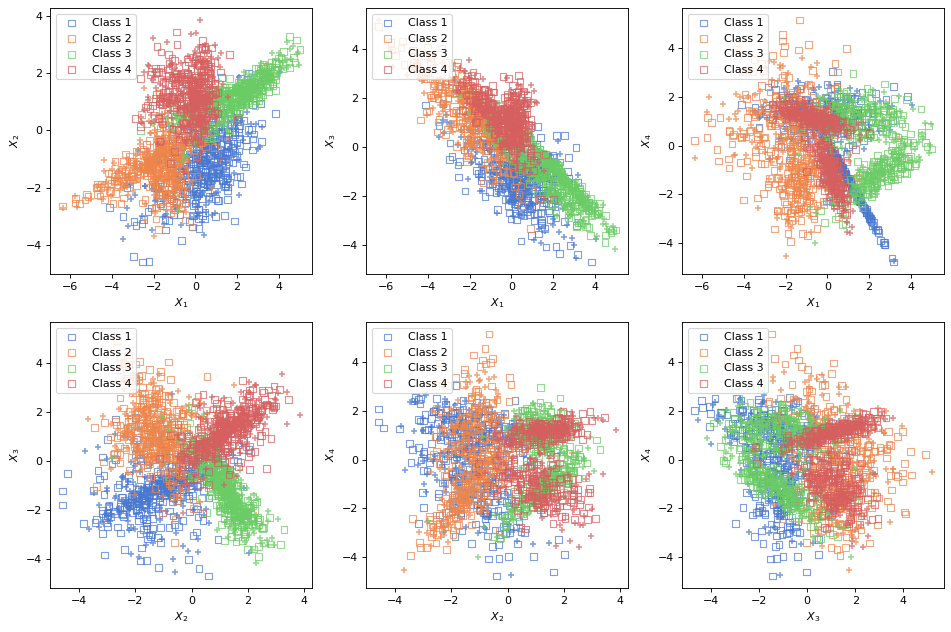

In [13]:
X,y = make_classification(
    n_samples=2000,n_features=4,n_classes=4,n_informative=3,class_sep=1.2,
    n_clusters_per_class=2,n_repeated=0,n_redundant=1,random_state=2022)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=0)
fig, ax = plt.subplots(2,3,figsize=(12,8),dpi=80)
ax = ax.flatten()
idx = 0
for i in range(3):
    for j in range(i+1,4):
        ax_ = ax[idx]
        for c in range(4):
            ax_.scatter(X_train[y_train == c,i],X_train[y_train == c,j],
                color='none',edgecolors=colors[c],alpha=0.7,marker="s",label="Class %d"%(c+1))
            ax_.scatter(X_test[y_test == c,i],X_test[y_test == c,j],
                color=colors[c],alpha=0.7,marker="+")
        ax_.legend(loc="upper left")
        ax_.set_xlabel("$X_%d$"%(i+1))
        ax_.set_ylabel("$X_%d$"%(j+1))
        idx += 1
plt.tight_layout()

数据集共有 $4$ 个特征，其中 $3$ 个是有效特征，$1$ 个冗余特征，对预测没有帮助

从散点图不难看出，$x^{(2)},x^{(3)}$ 是最有效的特征，其次是 $x^{(1)}$，$x^{(4)}$ 应该是函数构造出的冗余特征

首先，我们不限制模型的`max_depth`和`min_samples_leaf`，即不进行预剪枝

In [14]:
# 创建模型，进行训练
model = CARTreeClassifier()
model.fit(X_train,y_train)
# 评估模型
print("训练集准确率：%.4f"%accuracy_score(model.predict(X_train),y_train))
print("测试集准确率：%.4f"%accuracy_score(model.predict(X_test),y_test))

训练集准确率：1.0000
测试集准确率：0.8163


可以看到，模型在训练集的准确率可以到100%，但在测试集只有76%，模型出现了严重**过拟合**

我们尝试稍微限制模型的决策树增长能力进行预剪枝，设定`max_depth = 8`和`min_samples_leaf = 5`

In [15]:
# 创建模型，进行训练
model = CARTreeClassifier(max_depth=8,min_samples_leaf=5)
model.fit(X_train,y_train)
# 评估模型
print("训练集准确率：%.4f"%accuracy_score(model.predict(X_train),y_train))
print("测试集准确率：%.4f"%accuracy_score(model.predict(X_test),y_test))

训练集准确率：0.9033
测试集准确率：0.8475


此时可以观察到，**模型在训练集和测试集上的性能靠近了，过拟合得到缓解，模型在测试集上的性能也有所提高**

最后，我们来打印模型的**特征重要性**

In [16]:
for c in range(4):
    print("特征 X%d 的重要性：%.4f"%(c+1,model.feature_importance[c]))

特征 X1 的重要性：0.0358
特征 X2 的重要性：0.2265
特征 X3 的重要性：0.3061
特征 X4 的重要性：0.0372


可以看到，特征 $x^{(2)},x^{(3)}$ 对预测是最有效的，这**从上面的散点图中也能够观察并验证**

----

## **练习**

1. 目前最主流的机器学习模型就是决策树，尤其是CART树，或者一些基于CART树的增强型方法，对比你学习过的机器学习模型，谈谈你认为树模型成为主流算法的优势体现在哪些方面

2. 目前为止，我们已经学习了逻辑回归、朴素贝叶斯、KNN、SVM和决策树五大模型，下面我们来绘制它们在不同问题中的决策边界，使用下面的代码导入决策边界可视化函数

In [ ]:
# 从我们自己编写的文件中导入决策边界可视化函数
from source.utils import DecisionBoundaryDisplay

用下面的代码创建三种不同的数据集

In [ ]:
# 创建数据集
datasets = {
    "moons": make_moons(n_samples=100, noise=0.3, random_state=0),
    "circles": make_circles(n_samples=100, noise=0.2, factor=0.3, random_state=0),
    "linear": make_classification(n_samples=100, n_classes=2, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=2)
}

接下来，请你创建五种模型，用字典存储它们，然后调用`DecisionBoundaryDisplay()`可视化决策边界

In [ ]:
# 创建分类器
classifiers = {
    "LogisticRegression": LogisticRegression(),
    # 继续在这里添加模型
}

观察决策边界的结果，思考每种模型的特点和彼此之间的异同，加深你的理解

3. 请熟悉`sklearn`中`DecisionTreeClassifier()`和`DecisionTreeRegressor()`方法中的各个参数的含义，明确它们在构建决策树模型时所起的作用

4. 如果不设置`max_depth`和`min_samples_leaf`等预剪枝参数，**决策树模型非常容易过拟合**（尤其是回归问题），你可以尝试对比KNN模型来解释其原因

5. 对于前文CART树部分的实验，创建相同的数据集并分为训练集和测试集，采用**交叉验证**的方式，确定模型的最优参数`max_depth`和`min_samples_leaf`

6. **(编程训练)**：可以尝试完成下面的任务：
* 实现**CART回归树**，对比分类树的Gini特征重要性，思考回归树的特征重要性如何计算？
* 如果假设所提供的特征 $X$ 全是离散变量，CART树的实现应该做出什么样的修改？

----